# Step 01: Get a feel of data, draw it.

In [1]:
import cv2 as cv # for reading image data
import matplotlib.pyplot as plt
import pandas as pd 
import os

%matplotlib inline

In [2]:
label_map_table = {
    0: "normal",
    1: "void",
    2: "Horizontal Defect",
    3: "Vertical Defect",
    4: "Edge Defect",
    5: "Partical"
}

[Label] => 5; [Label Actually Means] => Partical


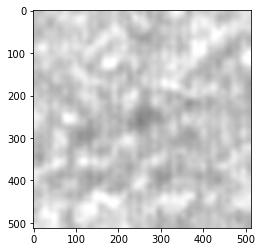

(512, 512, 3)


In [3]:
root_train = "../__HW5_DATA/train_images/"
root_test = "../__HW5_DATA/test_images/"
train_csv = "../__HW5_DATA/train.csv"
test_csv = "../__HW5_DATA/test.csv"
df_train = pd.read_csv(train_csv)

id = 4
png_img = cv.imread(root_train + df_train.ID[id])
label = df_train.Label[id]
print(f"[Label] => {df_train.Label[id]}; [Label Actually Means] => {label_map_table[label]}")
plt.imshow(png_img)
plt.show()

print(png_img.shape)

# Step 02: PyTorch: DataLoader

In [4]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2 as cv

class AOI_Dataset(Dataset):
    
    def __init__(self, target_csv, root_path):
        # register self
        self.target_csv = target_csv
        self.root_path = root_path
        
        # 1. Read CSV file through root_path
        self.df = pd.read_csv(self.target_csv)
        
        # 2. Remember the length
        self.count = len(self.df)
        
        # 3. to tensor
        self.to_tensor = transforms.ToTensor()
    
    def __getitem__(self, index):
        # Read images
        img = cv.imread(self.root_path + self.df.ID[index])

        # To Tensor
        img_tensor = self.to_tensor(img)
        
        # Get label
        label = self.df.Label[index]
        
        return (img_tensor, label)
    
    def __len__(self):
        return self.count

In [9]:
import torch

root_train = "../__HW5_DATA/train_images/"
train_csv = "../__HW5_DATA/train.csv"

Train_Dataset = AOI_Dataset(target_csv = train_csv, root_path = root_train)
Train_DataLoader = torch.utils.data.DataLoader(dataset = Train_Dataset, batch_size = 8, shuffle = True)

# Define a CNN model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( 3,  6, 3, padding = 1)
        self.conv2 = nn.Conv2d( 6, 16, 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 50, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(50 * 64 * 64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 50 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x)
        return x
    
lenet = LeNet()
lenet.to(device)

cuda:0


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=204800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

# Define loss and Hyper Parameter

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(lenet.parameters(), lr=1e-4)
epoch = 30

# Train

In [ ]:
from tqdm import tqdm
import time

tic = time.time()
train_acc_list = []
loss_list = []
for epoch in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Train_DataLoader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU        
        optimizer.zero_grad()

        outputs = lenet(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            loss_list.append(running_loss / 100)
            running_loss = 0.0
            
    correct = 0
    total = 0
    # Train
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
        for datum in tqdm(Train_DataLoader):

            imgs, labs = datum[0].to(device), datum[1].to(device)
            # calculate outputs by running images through the network 
            outputs = lenet(imgs.float())
            # the class with the highest energy is what we choose as prediction
            _, preds = torch.max(outputs.data, 1)
            
            total += labs.size(0)
            correct += (preds == labs).sum().item()
        train_acc_list.append(float(correct)/float(total))
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
        
toc = time.time()
print(f"Spend {round(toc - tic, 2)} (sec)")
print('Finished Training')

[1,   100] loss: 1.480
[1,   200] loss: 1.100
[1,   300] loss: 1.002


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:52<00:00,  6.05it/s]


Accuracy of the network on the train images: 65 %
[2,   100] loss: 0.875
[2,   200] loss: 0.766
[2,   300] loss: 0.744


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:48<00:00,  6.48it/s]


Accuracy of the network on the train images: 78 %
[3,   100] loss: 0.642
[3,   200] loss: 0.620
[3,   300] loss: 0.501


# Draw Acc Curve

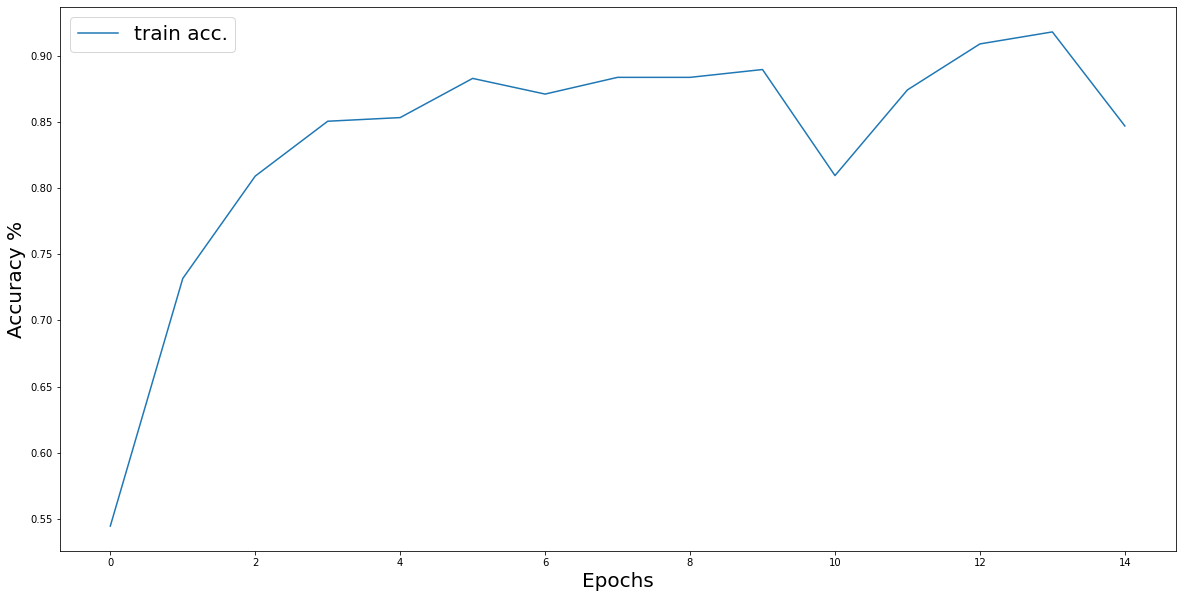

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.xlabel("Epochs", fontsize = 20)
plt.ylabel("Accuracy %", fontsize = 20)

plt.plot(train_acc_list, label = "train acc.")
plt.legend(loc=2, fontsize=20)
plt.show()

# Draw Loss Curve

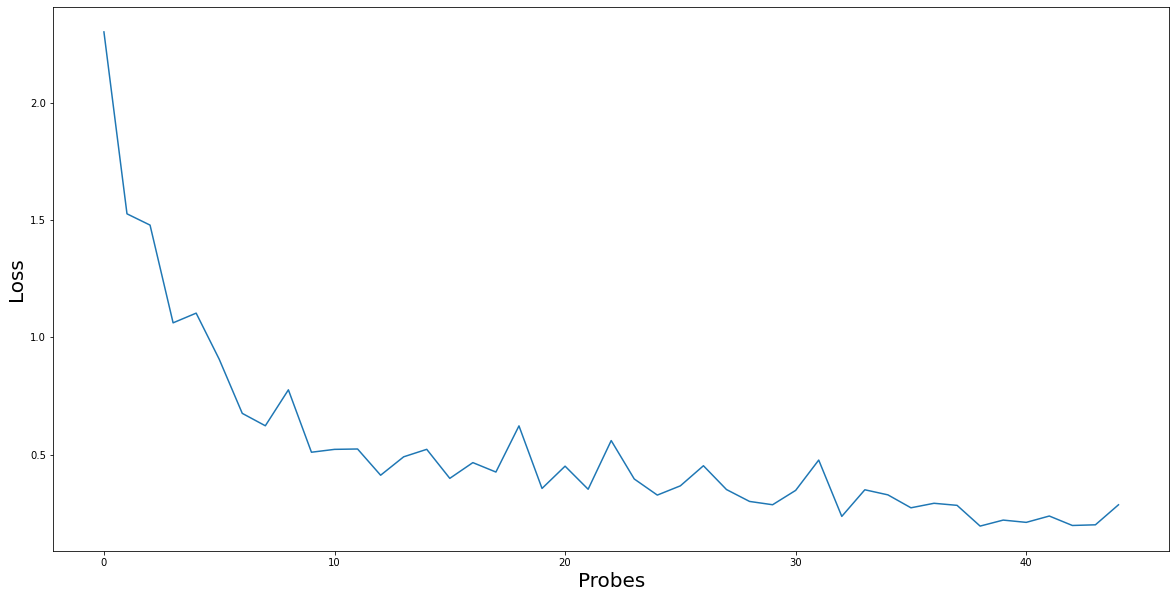

In [15]:
plt.figure(figsize=(20, 10))

plt.plot(loss_list)
plt.xlabel("Probes", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.show()

# Test

In [16]:
root_test = "../__HW5_DATA/test_images/"
test_csv = "../__HW5_DATA/test.csv"

Test_Dataset = AOI_Dataset(target_csv = test_csv, root_path = root_test)
Test_DataLoader = torch.utils.data.DataLoader(dataset = Test_Dataset, batch_size = 1, shuffle = False)

In [17]:
test_csv = "../__HW5_DATA/test.csv"
df_test = pd.read_csv(test_csv)
df_test_np = df_test.to_numpy()

count = -1
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for datum in tqdm(Test_DataLoader):
        count = count + 1
        imgs = datum[0].to(device)
        # calculate outputs by running images through the network 
        outputs = lenet(imgs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs.data, 1)
        df_test_np[count][1] = float(preds)
        
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])

100%|████████████████████████████████████████████████████████████████████████████| 10142/10142 [04:12<00:00, 40.21it/s]


In [18]:
df = pd.DataFrame(df_test_np, columns = ['ID','Label'])
df.to_csv("test02_0516.csv", index=False)